# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, gridspec
import os
import cv2
from PIL import Image

from scipy.interpolate import splrep, splev
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import DBSCAN
from skimage import feature
from skimage import img_as_float
from skimage.filters import gabor
from skimage.transform import hough_line, hough_line_peaks
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA


import matplotlib.cm as cm
import time
import math
from copy import deepcopy
from collections import deque
from ultralytics import YOLO

In [2]:
claheFilter = cv2.createCLAHE(clipLimit=40)

In [3]:
# filepath = r"C:\Users\rishi\Downloads\Dataset_preprocessed_yolo\test\images\DJI_0013_1_3_JPG.rf.cf8a8b0c38ec63833cb8a2420c1fd791.jpg"
# filepathArithmeticError = "TEST_DS/test/DJI_0013_1_3_JPG.rf.cf8a8b0c38ec63833cb8a2420c1fd791.jpg"

In [4]:
files = os.listdir("TEST_DS/test")
print("DJI_0013_1_3_JPG.rf.cf8a8b0c38ec63833cb8a2420c1fd791.jpg" in files)

True


In [5]:
# filepath = "Dataset2/train/DJI_0002_0_5_JPG.rf.70b07b52bde88868cd7020f164a42318.jpg"
filepath = "Dataset2/test/DJI_0024_2_6_JPG.rf.084dca74cd5c0ee18bf2c6f1dc960af0.jpg"

params for pathing algo

In [6]:
HIGH_THRESHOLD = 0.85  # must include if confidence >= HIGH_THRESHOLD
LOW_THRESHOLD = 0.35   # must exclude if confidence <= LOW_THRESHOLD

# Functions

## Mask creation

In [7]:
def loadAndReturnNormalisedHSV(filepath):
    """
    Input: filepath of rgb image
    Output:
        Image converted to HSV colorspace, then grayscaled and normalised
    """
    img = Image.open(filepath)
    img_arr = np.array(img)
    img_direct_grayscale = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_direct_grayscale, cmap = "gray")
    plt.title("direct grayscale")
    plt.show()
    
    hsv_image = cv2.cvtColor(img_arr, cv2.COLOR_BGR2HSV)
    grayscale_hsv = np.mean(hsv_image, axis=-1)
    plt.imshow(grayscale_hsv, cmap = "gray")
    plt.title("HSV grayscale")
    plt.show()
    # print(grayscale_hsv.shape, grayscale_hsv.dtype)
    # grayscale_hsv = claheFilter.apply(grayscale_hsv)
    norm_hsv = (((grayscale_hsv - grayscale_hsv.min()) / (grayscale_hsv.max() - grayscale_hsv.min()))*255).astype(np.uint8)
    # norm_hsv = np.array(norm_hsv)
    # print(norm_hsv.shape, norm_hsv.dtype)
    # print(norm_hsv)
    
    norm_hsv = claheFilter.apply(norm_hsv)
    return norm_hsv

In [8]:
def createPlantMask(filepath):
    cmap = cm.get_cmap('jet')
    clahe_norm_hsv = loadAndReturnNormalisedHSV(filepath)
    
    clahe_colored_overlay = cmap(clahe_norm_hsv)[:, :, :3]

    selected_channel = clahe_colored_overlay[:,:,0]

    selected_channel_gray = (selected_channel*255).astype(np.uint8)

    return selected_channel

In [9]:
def bfs(start_i, start_j, closed_mask_small, visited):
    q = deque()
    q.append((start_i, start_j))
    visited[start_i, start_j] = True
    region_pixels = []  # To store all connected pixels

    # Use 4-neighborhood connectivity (you can extend to 8 if needed)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while q:
        i, j = q.popleft()
        region_pixels.append((i, j))
        for di, dj in neighbors:
            ni, nj = i + di, j + dj
            if (0 <= ni < closed_mask_small.shape[0] and 0 <= nj < closed_mask_small.shape[1]):
                if (not visited[ni, nj]) and (closed_mask_small[ni, nj] == 0.0):
                    visited[ni, nj] = True
                    q.append((ni, nj))
    return region_pixels

In [10]:
def createDirtMask(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    image_float = img_as_float(image)
    frequency = 0.2  # Adjust based on the texture scale
    theta = np.pi / 4  # Orientation of the filter (in radians)
    
    # Apply the Gabor filter (returns real and imaginary responses)
    real_response, imaginary_response = gabor(image_float, frequency=frequency, theta=theta)
    
    # Compute the magnitude of the response
    magnitude = np.sqrt(real_response**2 + imaginary_response**2)

    # Simple segmentation: threshold the magnitude response
    threshold_value = magnitude.mean()  # Example threshold (could also use Otsu's method, etc.)
    segmented_texture = magnitude > threshold_value

    gabor_mask = (segmented_texture.astype(np.uint8))*255

    selected_kernel_sizes = [17, 9]
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (selected_kernel_sizes[0], selected_kernel_sizes[0]))
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (selected_kernel_sizes[1], selected_kernel_sizes[1]))
    
    closed_mask_large = cv2.morphologyEx(gabor_mask, cv2.MORPH_CLOSE, kernel_large)
    closed_mask_small = cv2.morphologyEx(gabor_mask, cv2.MORPH_CLOSE, kernel_small)
    
    closed_mask_large = np.abs(closed_mask_large) > 0
    closed_mask_small = np.abs(closed_mask_small) > 0

    overlap_mask = np.zeros(closed_mask_large.shape)
    for i in range(overlap_mask.shape[0]):
        for j in range(overlap_mask.shape[1]):
            if(not(closed_mask_large[i][j]) and not(closed_mask_small[i][j])):
                overlap_mask[i][j] = 255

    visited = np.zeros_like(overlap_mask, dtype=bool)

    # This will hold the refined dirt area (True where dirt is found)
    dirt_area_map = np.zeros_like(overlap_mask, dtype=bool)
    
    for i in range(overlap_mask.shape[0]):
        for j in range(overlap_mask.shape[1]):
            if (overlap_mask[i, j]==255.0) and (visited[i, j] == False):
                region = bfs(i, j, closed_mask_small, visited)
                # Optionally, filter out small regions (noise) by size:
                if len(region) >= 50:  # for example, only accept regions with at least 50 pixels
                    for (pi, pj) in region:
                        dirt_area_map[pi, pj] = True

    return dirt_area_map

## Pathing

In [11]:
def euclidean_distance(p1, p2):
    return math.hypot(p1["x"] - p2["x"], p1["y"] - p2["y"])

In [12]:
def categorize_detections(detections):
    mandatory = []
    optional = []
    excluded = []
    print(f"HIGH_THRESHOLD: {HIGH_THRESHOLD}\nLOW_THRESHOLD: {LOW_THRESHOLD}")
    for det in detections:
        conf = det["confidence"]
        if conf >= HIGH_THRESHOLD:
            mandatory.append(det)
        elif conf <= LOW_THRESHOLD:
            excluded.append(det)
        else:
            optional.append(det)
    return mandatory, optional, excluded

In [13]:
def greedy_tsp(nodes):
    """Simple greedy TSP for mandatory nodes.
       Returns a list representing the order of nodes to visit."""
    if not nodes:
        return []
    
    remaining = nodes.copy()
    current = remaining.pop(0)
    tour = [current]
    
    while remaining:
        # choose the nearest neighbor
        next_node = min(remaining, key=lambda node: euclidean_distance(current, node))
        tour.append(next_node)
        remaining.remove(next_node)
        current = next_node
        
    return tour


In [14]:
def compute_insertion_cost(tour, node, insert_position):
    """Compute the cost added to the tour by inserting node at insert_position.
       insert_position is the index in tour where the node is inserted (before that element).
       Assumes tour is circular: from last node back to first node."""
    n = len(tour)
    if n == 0:
        return 0
    # Inserting node between tour[insert_position - 1] and tour[insert_position]
    prev_node = tour[insert_position - 1]
    next_node = tour[insert_position % n]  # modulo for circularity
    cost_without = euclidean_distance(prev_node, next_node)
    cost_with = euclidean_distance(prev_node, node) + euclidean_distance(node, next_node)
    return cost_with - cost_without

In [15]:
def try_inserting_optional(tour, optional_nodes, alpha, beta):
    """Insert optional nodes into the tour based on the metric.
       When starting from a single node, force an initial insertion to expand the tour."""
    updated_tour = deepcopy(tour)
    
    # If the tour has only one node and there are optional nodes available,
    # force the insertion of the optional node with the highest confidence.
    if len(updated_tour) == 1 and optional_nodes:
        best_node = max(optional_nodes, key=lambda d: d["confidence"])
        updated_tour.append(best_node)
        optional_nodes.remove(best_node)
        print(f"Forced insertion of node {best_node['id']} to expand tour.")

    inserted = True
    # Continue trying to insert as long as one node qualifies
    while inserted and optional_nodes:
        inserted = False
        best_gain = 0
        best_insertion = None  # (node, position, gain)
        # Evaluate each optional node for all possible insertion points
        for node in optional_nodes:
            n = len(updated_tour)
            for pos in range(n):
                extra_cost = compute_insertion_cost(updated_tour, node, pos)
                metric = alpha * node["confidence"] - beta * extra_cost
                if metric > best_gain:
                    best_gain = metric
                    best_insertion = (node, pos, extra_cost)
        # If a beneficial insertion is found, add the node into the tour.
        if best_insertion:
            node, pos, extra_cost = best_insertion
            updated_tour.insert(pos, node)
            optional_nodes.remove(node)
            inserted = True
            print(f"Inserted node {node['id']} at position {pos} with extra cost {extra_cost:.2f} and gain {best_gain:.2f}")
    return updated_tour

In [16]:
def create_path(detections, alpha=0.85, beta=0.35):
    mandatory, optional, excluded = categorize_detections(detections)
    print("Mandatory detections:", [d["id"] for d in mandatory])
    print("Optional detections:", [d["id"] for d in optional])
    print("Excluded detections:", [d["id"] for d in excluded])
    
    # Build initial tour based on mandatory nodes or seed from optional if mandatory is empty.
    if mandatory:
        tour = greedy_tsp(mandatory)
        print("Initial mandatory tour:", [d["id"] for d in tour])
    elif optional:
        best_node = max(optional, key=lambda d: d["confidence"])
        tour = [best_node]
        optional.remove(best_node)
        print("No mandatory nodes. Starting tour with optional node:", best_node["id"])
    else:
        print("No nodes available for tour.")
        return
    
    # Insert remaining optional nodes if beneficial
    final_tour = try_inserting_optional(tour, optional, alpha, beta)
    print("Final tour:", [d["id"] for d in final_tour])
    
    # Calculate the total distance of the final (circular) tour
    total_distance = 0.0
    n = len(final_tour)
    for i in range(n):
        total_distance += euclidean_distance(final_tour[i], final_tour[(i+1) % n])
    print(f"Total tour distance: {total_distance:.2f}")

    return final_tour

## Image sharpening

# Crop Mask Generation

## Crop Area Identification

C:\Users\arvin\AppData\Local\Temp\ipykernel_20900\2007548969.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


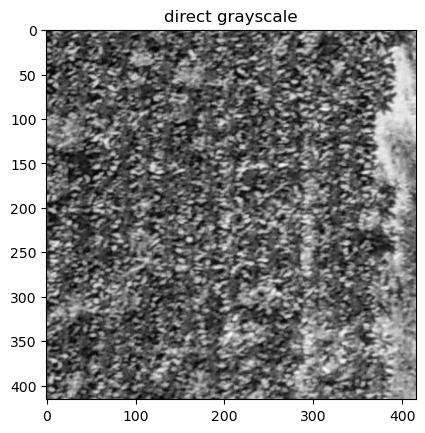

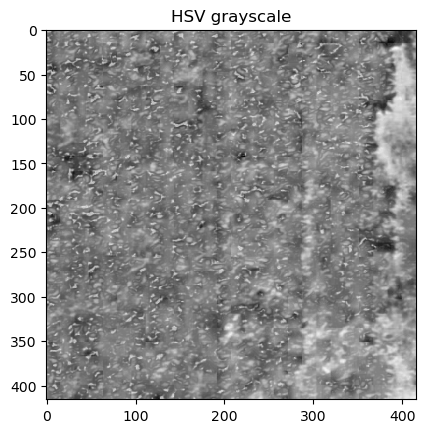

(-0.5, 415.5, 415.5, -0.5)

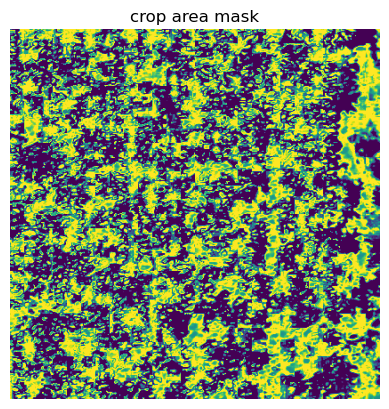

In [17]:
crop_area_mask = createPlantMask(filepath)
plt.imshow(crop_area_mask)
plt.title("crop area mask")
plt.axis('off')

## Dirt Area Identification

(-0.5, 415.5, 415.5, -0.5)

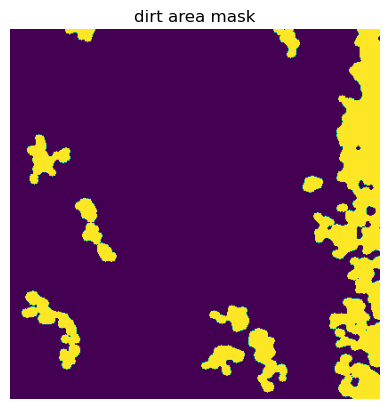

In [18]:
dirt_area_mask = createDirtMask(filepath)
plt.imshow(dirt_area_mask)
plt.title("dirt area mask")
plt.axis('off')

## Blocking dirt areas in crop mask

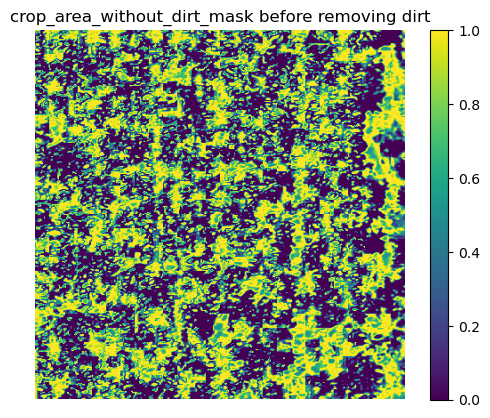

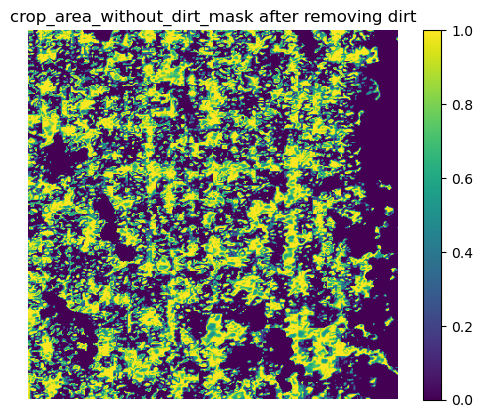

In [19]:
crop_area_without_dirt_mask = crop_area_mask.copy()
plt.imshow(crop_area_without_dirt_mask)
plt.colorbar()
plt.title("crop_area_without_dirt_mask before removing dirt")
plt.axis('off')

plt.show()

for i in range(crop_area_mask.shape[0]):
    for j in range(crop_area_mask.shape[1]):
        if(dirt_area_mask[i][j]):
            crop_area_without_dirt_mask[i][j] = 0

plt.imshow(crop_area_without_dirt_mask)
plt.title("crop_area_without_dirt_mask after removing dirt")
plt.axis('off')
plt.colorbar()

## Dilation

In [20]:
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(crop_area_without_dirt_mask, kernel, iterations=1)

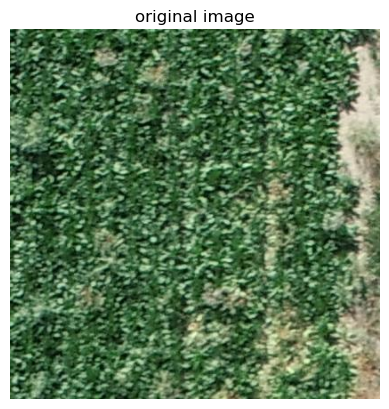

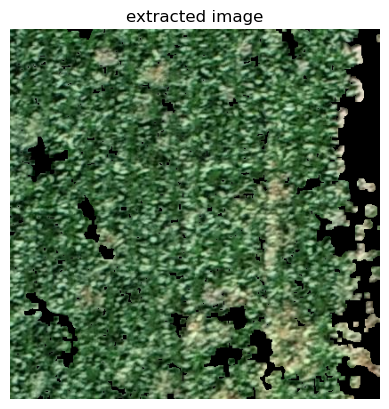

True

In [21]:
ori_img = cv2.imread(filepath)
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
plt.imshow(ori_img)
plt.title("original image")
plt.axis('off')
plt.show()

extracted_img = ori_img.copy()
extracted_img[dilated_mask == 0] = [0,0,0]
plt.imshow(extracted_img)
plt.title("extracted image")
plt.axis('off')
plt.show()

cv2.imwrite("Demo images/demo.jpg", extracted_img)

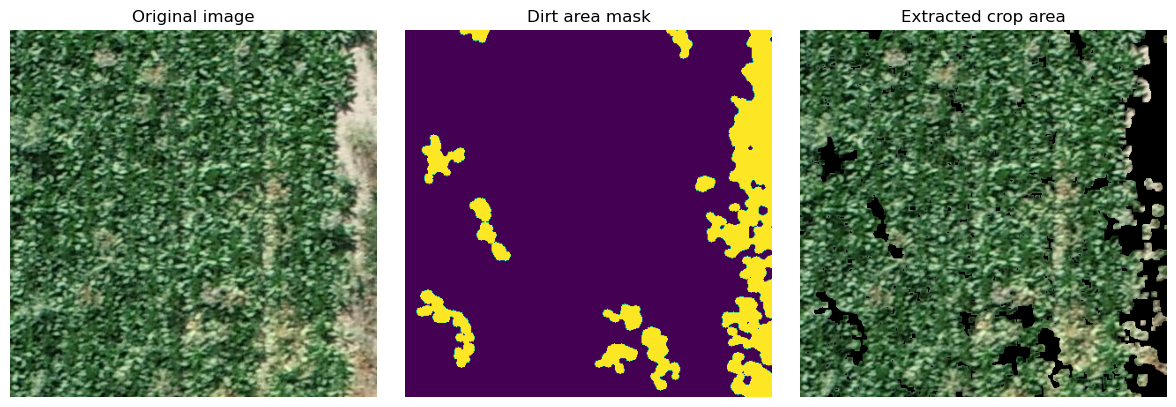

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(ori_img)
axs[0].set_title("Original image")
axs[0].axis('off')

axs[1].imshow(dirt_area_mask)
axs[1].set_title("Dirt area mask")
axs[1].axis('off')

axs[2].imshow(extracted_img)
axs[2].set_title("Extracted crop area")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Weed Detection using ML

In [23]:
# Load trained YOLO model
model = YOLO("best_yolo11s.pt")

#Load demo image
# demo_image = cv2.cvtColor(cv2.imread("Demo images/demo.jpg"), cv2.COLOR_BGR2RGB)
demo_image = cv2.imread("Demo images/demo.jpg")
# Run inference on an image
results = model(demo_image)

# Extract bounding boxes [(x, y, w, h)]
boxes = []
for r in results:
    for box in r.boxes.xywh:  # YOLOv8 outputs (center_x, center_y, width, height)
        x, y, w, h = box.tolist()
        x = int(x - w / 2)  # Convert center_x to top-left x
        y = int(y - h / 2)  # Convert center_y to top-left y
        boxes.append((x, y, int(w), int(h)))  # Save as (x, y, w, h)

print("Extracted boxes:", boxes)
# plt.imshow(demo_image)


0: 416x416 6 weeds, 23.0ms
Speed: 9.1ms preprocess, 23.0ms inference, 362.2ms postprocess per image at shape (1, 3, 416, 416)
Extracted boxes: [(348, 204, 35, 35), (8, 301, 44, 32), (92, 19, 31, 26), (1, 99, 43, 42), (193, 322, 60, 39), (143, 37, 38, 31)]


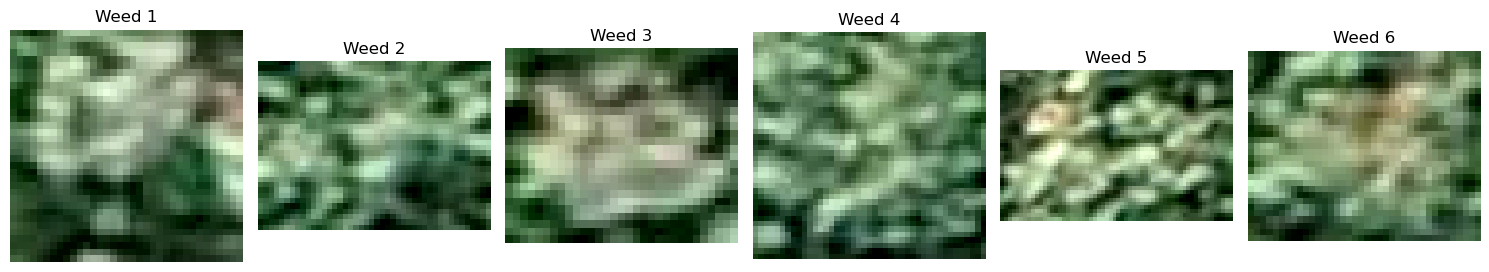

In [24]:
sharpen_kernel = np.array([[0, -1,  0],
                           [-1, 5, -1],
                           [0, -1,  0]])


original_image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1, len(results[0].boxes), figsize=(15, 5))  # Adjust figsize as needed

for idx, box in enumerate(results[0].boxes.xywh):  # xywh = (center_x, center_y, width, height)
    cx, cy, w, h = box.tolist()
    x = int(cx - w / 2)
    y = int(cy - h / 2)
    w, h = int(w), int(h)
    
    # Crop the detected region
    crop = original_image[y:y+h, x:x+w]

    # Sharpen the crop 

    #kernel
    # sharpened = cv2.filter2D(crop, -1, sharpen_kernel)
    # sharpened_rgb = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)

    #Unsharp masking
    blurred = cv2.GaussianBlur(crop, (9, 9), 10.0)
    sharpened_rgb = cv2.addWeighted(crop, 1.5, blurred, -0.5, 0)

    #CLAHE
    # lab = cv2.cvtColor(crop, cv2.COLOR_BGR2LAB)
    # l, a, b = cv2.split(lab)
    
    # clahe_sharpen = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    # cl = clahe_sharpen.apply(l)
    
    # merged = cv2.merge((cl, a, b))
    # sharpened_rgb = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)


    # Display
    if len(results[0].boxes) > 1:
        axs[idx].imshow(sharpened_rgb)
        axs[idx].set_title(f"Weed {idx+1}")
        axs[idx].axis('off')
    else:
        axs.imshow(sharpened_rgb)
        axs.set_title(f"Weed {idx+1}")
        axs.axis('off')

plt.tight_layout()
plt.show()

## Weed annotation

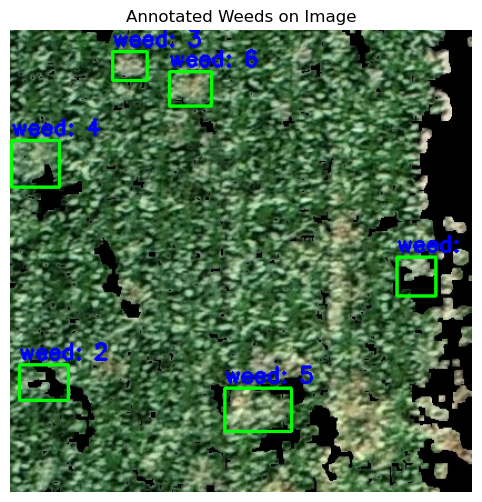

In [25]:
# Loop over each detected bounding box and draw it.
demo_image = cv2.imread("Demo images/demo.jpg")
weed_count = 0
total_weed_area = 0
font_color = (0,0,255)
color = (255,0,0)
for (x, y, w, h) in boxes:
    cx, cy = x + w//2, y + h//2
    if dilated_mask.any() > 0:
        color = (0, 255, 0)  # Green for boxes in crop areas
        weed_count += 1
        weed_area = w*h
        total_weed_area += weed_area
    cv2.rectangle(demo_image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(demo_image, f"weed: {weed_count}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.65, font_color, 2)

plt.figure(figsize=(8, 6))
plt.imshow(demo_image)
# plt.imshow(cv2.cvtColor(demo_image, cv2.COLOR_BGR2RGB))
plt.title("Annotated Weeds on Image")
plt.axis('off')
plt.show()

# Weed density estimation

1 pixel ~ 1 cm
by dataset specification

1 pixel area ~ 1cm2 = 0.0001 m2


In [26]:
total_crop_area = 0
for i in range(dilated_mask.shape[0]):
    for j in range(dilated_mask.shape[1]):
        if(dilated_mask[i][j]>0):
            total_crop_area+=1
print(total_crop_area)

151917


In [27]:
print(total_weed_area)

8763


In [28]:
weed_density_wpp = (weed_count / total_crop_area)*10000
total_crop_area -= total_weed_area
weed_density_perc = total_weed_area / total_crop_area

print("Total crop area (pixels):", total_crop_area)
print("Total crop area (m2):", total_crop_area/10000)
print("Total weed area (pixels):", total_weed_area)
print("Total weed area (m2):", total_weed_area/10000)
print("Number of weeds in crop areas:", weed_count)
print("Weed density (weeds per pixel, ~ weeds/m2):", weed_density_wpp)
print("Weed density (% of crop area):", weed_density_perc)

Total crop area (pixels): 143154
Total crop area (m2): 14.3154
Total weed area (pixels): 8763
Total weed area (m2): 0.8763
Number of weeds in crop areas: 6
Weed density (weeds per pixel, ~ weeds/m2): 0.39495250696103795
Weed density (% of crop area): 0.06121379772832055


## Image subdivision

In [29]:
# Define grid cell size (in pixels)
# cell_size = 50
cell_size = crop_area_mask.shape[0]//9 # adjust based on your image resolution

# Determine the number of cells in each direction
# n_rows = height // cell_size
# n_cols = width // cell_size

n_rows = 9
n_cols = 9

# Create an empty density grid
density_grid = np.zeros((n_rows, n_cols), dtype=float)

## Density estimation

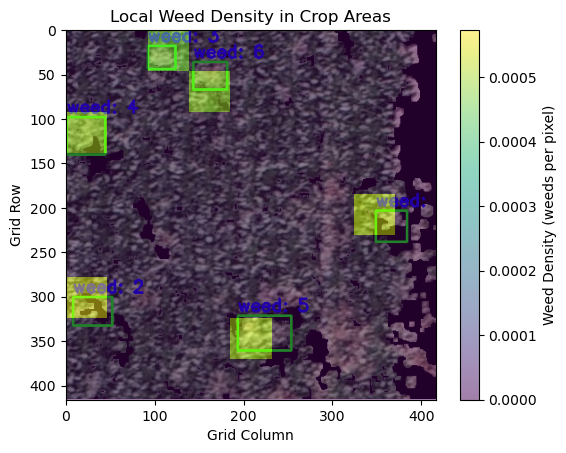

In [30]:
for i in range(n_rows):
    for j in range(n_cols):
        # Define cell boundaries
        row_start = i * cell_size
        row_end = min((row_start + cell_size), crop_area_without_dirt_mask.shape[0])
        col_start = j * cell_size
        col_end = min((col_start + cell_size), crop_area_without_dirt_mask.shape[1])

        # Crop mask for the cell
        cell_crop_mask = dilated_mask[row_start:row_end, col_start:col_end]
        cell_area = np.sum(cell_crop_mask>0)  # crop area in this cell

        # Count weeds in the cell (check if bounding box center lies in this cell and in crop area)
        cell_weed_count = 0
        for (x, y, w, h) in boxes:
            cx, cy = x + w//2, y + h//2
            if row_start <= cy < row_end and col_start <= cx < col_end:
                    cell_weed_count += 1

        # Compute density (avoid division by zero)
        if cell_area > 0:
            density_grid[i, j] = cell_weed_count / cell_area
        else:
            density_grid[i, j] = 0

# Visualize the density grid
# plt.figure(figsize=(8, 6))bfs

# plt.imshow(crop_area_without_dirt_mask)
plt.imshow(demo_image) # , cmap = "jet")
plt.imshow(density_grid, cmap='viridis', interpolation='nearest', alpha=0.5, extent=[0, demo_image.shape[1], demo_image.shape[0], 0])
plt.title("Local Weed Density in Crop Areas")
plt.xlabel("Grid Column")
plt.ylabel("Grid Row")
plt.colorbar(label="Weed Density (weeds per pixel)")
# plt.axis('off')
plt.show()

# Pathing between weeds

In [32]:
results[0].boxes.conf.cpu().numpy()

array([    0.48357,     0.46891,     0.45441,      0.4076,     0.37457,     0.36795], dtype=float32)

In [33]:
results[0].boxes.xywh.cpu().numpy()

array([[     366.86,      222.43,      35.865,      35.187],
       [     30.374,      317.92,      44.442,      32.819],
       [     108.25,       32.82,      31.747,      26.659],
       [     22.909,      120.25,        43.1,      42.263],
       [     223.62,      342.65,      60.138,      39.404],
       [     162.94,      53.003,      38.259,      31.321]], dtype=float32)

In [34]:
detections = []
for i in range(len(results[0])):
    d = {}
    d["id"] = i+1
    d["x"] = results[0].boxes.xywh.cpu().numpy()[i][0]
    d["y"] = results[0].boxes.xywh.cpu().numpy()[i][1]
    d["w"] = results[0].boxes.xywh.cpu().numpy()[i][2]
    d["h"] = results[0].boxes.xywh.cpu().numpy()[i][3]
    d["confidence"] = results[0].boxes.conf.cpu().numpy()[i]
    # print(f"id: {i+1}, x: {results[0].boxes.xywh.cpu().numpy()[i][0]}, y: {results[0].boxes.xywh.cpu().numpy()[i][1]}, confidence: {results[0].boxes.conf.cpu().numpy()[i]} ")
    detections.append(d)
detections

[{'id': 1,
  'x': 366.86438,
  'y': 222.42503,
  'w': 35.864685,
  'h': 35.187317,
  'confidence': 0.48356685},
 {'id': 2,
  'x': 30.374441,
  'y': 317.92383,
  'w': 44.442463,
  'h': 32.818604,
  'confidence': 0.46891364},
 {'id': 3,
  'x': 108.25308,
  'y': 32.820206,
  'w': 31.746765,
  'h': 26.659304,
  'confidence': 0.45441326},
 {'id': 4,
  'x': 22.909039,
  'y': 120.24893,
  'w': 43.10002,
  'h': 42.262604,
  'confidence': 0.40760162},
 {'id': 5,
  'x': 223.62341,
  'y': 342.6517,
  'w': 60.13794,
  'h': 39.403564,
  'confidence': 0.37457216},
 {'id': 6,
  'x': 162.94495,
  'y': 53.00318,
  'w': 38.25879,
  'h': 31.321304,
  'confidence': 0.36795354}]

Inclusion Thresholds

In [35]:
total = 0.0
for i in range(len(detections)):
    for j in range(i+1, len(detections)):
        dist = (((detections[j]["x"]-detections[i]["x"])**2) + ((detections[j]["y"]-detections[i]["y"])**2))**0.5
        total+=dist
        print(dist)

print("avg: ", total/36)

349.779204948036
320.67084994730163
358.8108700467049
187.0091617612513
265.1167606640926
295.5489243324098
197.81581544359523
194.824626669768
296.2395878742317
122.17768746239568
330.6143681519329
58.297105418569046
299.5817937780814
155.34492376708562
295.9360517328569
avg:  103.54910366661981


Weights for the optional node decision metric

## With tuned parameters

In [36]:
ALPHA = 1.0   # weight for the confidence score
BETA = 0.001   # weight for the insertion cost (distance)

In [37]:
tour = create_path(detections, alpha=ALPHA, beta=BETA)

HIGH_THRESHOLD: 0.85
LOW_THRESHOLD: 0.35
Mandatory detections: []
Optional detections: [1, 2, 3, 4, 5, 6]
Excluded detections: []
No mandatory nodes. Starting tour with optional node: 1
Forced insertion of node 2 to expand tour.
Inserted node 5 at position 0 with extra cost 32.05 and gain 0.34
Inserted node 4 at position 2 with extra cost 206.85 and gain 0.20
Inserted node 3 at position 2 with extra cost 84.04 and gain 0.37
Inserted node 6 at position 2 with extra cost 2.74 and gain 0.37
Final tour: [5, 1, 6, 3, 4, 2]
Total tour distance: 1025.24


## Overlaying result on img

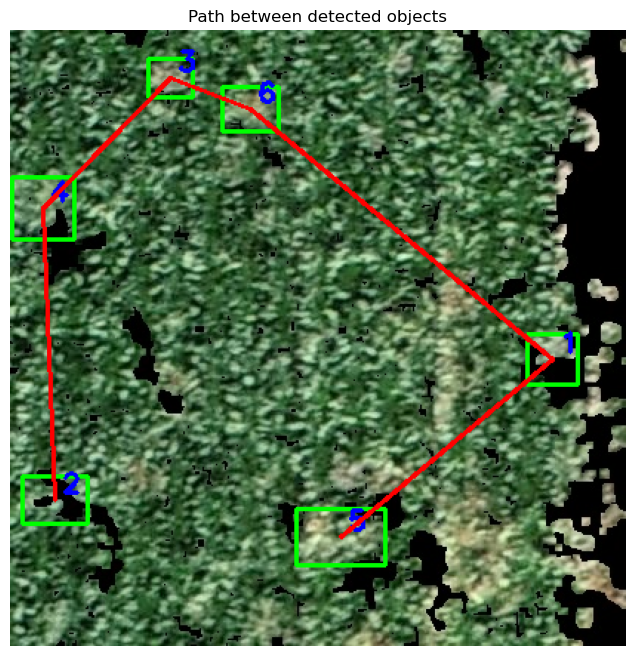

In [38]:

# Load image
image = cv2.imread("Demo images/demo.jpg") # stored in rgb format

# Colors
color = (0, 255, 0)       # Green for boxes and text
path_color = (255, 0, 0)  # Red for path
text_color = (0, 0, 255)

# Draw boxes and labels
for det in tour:
    x, y = int(det['x']), int(det['y'])
    w, h = int(det['w']), int(det['h'])
    top_left = (x - w // 2, y - h // 2)
    bottom_right = (x + w // 2, y + h // 2)
    
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    cv2.putText(image, f"{det['id']}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)

# Draw path connecting detections
for i in range(len(tour)-1):
    pt1 = (int(tour[i]['x']), int(tour[i]['y']))
    pt2 = (int(tour[i+1]['x']), int(tour[i+1]['y']))
    cv2.line(image, pt1, pt2, path_color, 2)

# Display image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title("Path between detected objects")
plt.axis('off')
plt.show()

## With default parameters

In [39]:
tour = create_path(detections)

HIGH_THRESHOLD: 0.85
LOW_THRESHOLD: 0.35
Mandatory detections: []
Optional detections: [1, 2, 3, 4, 5, 6]
Excluded detections: []
No mandatory nodes. Starting tour with optional node: 1
Forced insertion of node 2 to expand tour.
Final tour: [1, 2]
Total tour distance: 699.56


## Overlaying result on img

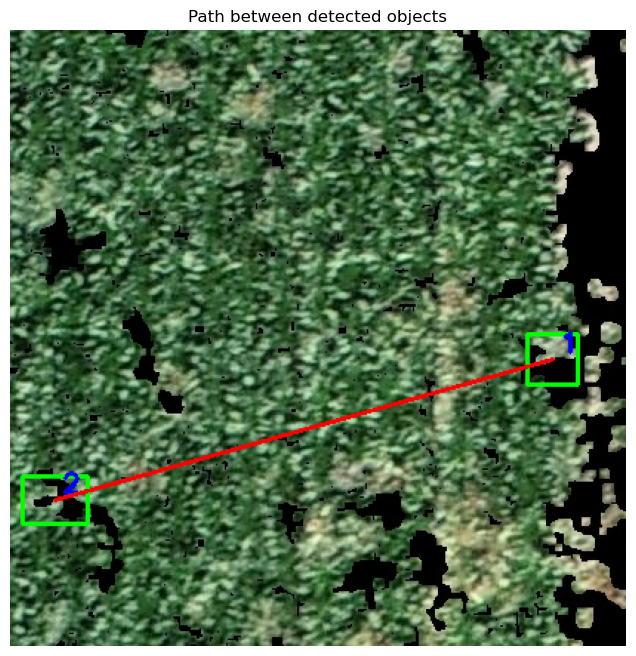

In [40]:

# Load image
image = cv2.imread("Demo images/demo.jpg") # stored in rgb format

# Colors
color = (0, 255, 0)       # Green for boxes and text
path_color = (255, 0, 0)  # Red for path
text_color = (0, 0, 255)

# Draw boxes and labels
for det in tour:
    x, y = int(det['x']), int(det['y'])
    w, h = int(det['w']), int(det['h'])
    top_left = (x - w // 2, y - h // 2)
    bottom_right = (x + w // 2, y + h // 2)
    
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    cv2.putText(image, f"{det['id']}", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)

# Draw path connecting detections
for i in range(len(tour)-1):
    pt1 = (int(tour[i]['x']), int(tour[i]['y']))
    pt2 = (int(tour[i+1]['x']), int(tour[i+1]['y']))
    cv2.line(image, pt1, pt2, path_color, 2)

# Display image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title("Path between detected objects")
plt.axis('off')
plt.show()